## Importing Libraries


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt


c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Data Import and Exploration

In [2]:
url = 'https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_hospital_load.csv'
data = pd.read_csv(url, index_col=[0], parse_dates=[0])

In [4]:
data


,y
ds,
2015-01-01 01:00:00,778.007969
2015-01-01 02:00:00,776.241750
2015-01-01 03:00:00,779.357338
2015-01-01 04:00:00,778.737196
2015-01-01 05:00:00,787.835835
...,...
2015-12-31 20:00:00,845.563081
2015-12-31 21:00:00,827.530521
2015-12-31 22:00:00,829.256300


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 01:00:00 to 2016-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


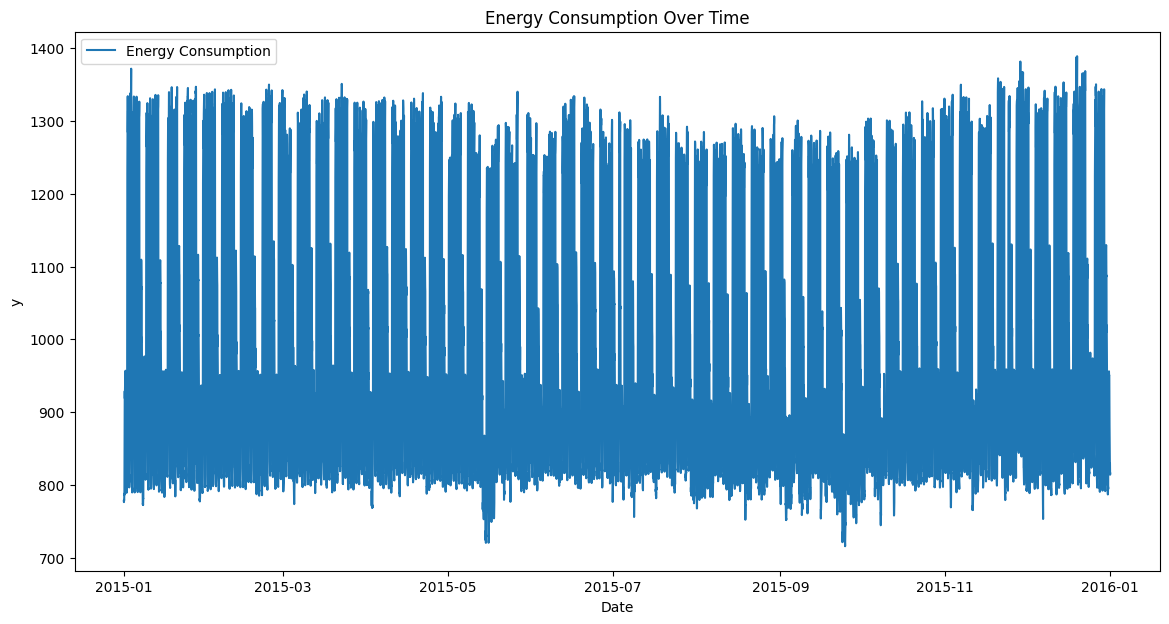

In [ ]:
def plot_energy_consumption(df):
    # Plot the energy consumption over time
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['y'], label='Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.title('Energy Consumption Over Time')
    plt.legend()
    plt.show()

plot_energy_consumption(data)

## Prophet Model Implementation



In [48]:
df = data.copy()

# Reset the index to make 'datetime' a column again
df.reset_index(inplace=True)


In [14]:
#Choosing Date to split Data into train and validation 

time_split = '2015-12-29'

In [26]:
#Splitting Data into train and val

train = df[df['ds'] < time_split]
val = df[df['ds'] >= time_split]

KeyError: 'ds'

In [9]:
train.head()

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [ ]:
val.head()

,ds,y
7175,2015-10-27 00:00:00,820.341131
7176,2015-10-27 01:00:00,818.556432
7177,2015-10-27 02:00:00,811.742936
7178,2015-10-27 03:00:00,818.953835
7179,2015-10-27 04:00:00,909.224690


## Training the Prophet Model

In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the training dataset
model.fit(train[['ds', 'y']])

# Create a DataFrame for future predictions (5 days into the future)
future = model.make_future_dataframe(periods=5*24, freq='H')  # 5 days * 24 hours

# Make predictions
forecast = model.predict(future)

# Display the forecast
print("\nForecasted data:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqewdzqhu/3t5c31se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqewdzqhu/s1e09473.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45880', 'data', 'file=/tmp/tmpqewdzqhu/3t5c31se.json', 'init=/tmp/tmpqewdzqhu/s1e09473.json', 'output', 'file=/tmp/tmpqewdzqhu/prophet_modelxbsx0ywz/prophet_model-20240531192134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Forecasted data:
                      ds         yhat  yhat_lower   yhat_upper
8802 2016-01-02 19:00:00  1073.007959  974.597827  1176.139860
8803 2016-01-02 20:00:00   996.781609  897.954233  1101.588907
8804 2016-01-02 21:00:00   938.898846  825.843052  1045.373735
8805 2016-01-02 22:00:00   905.260744  797.824064  1010.906646
8806 2016-01-02 23:00:00   891.483905  776.249846   993.486726


## Compare Predictions with Validation Data

In [27]:
# Filter the forecast to only include the validation period
forecast_val = forecast[forecast['ds'] >= time_split]

# Merge the validation data with the forecasted data
comparison = val[['ds', 'y']].merge(forecast_val[['ds', 'yhat']], on='ds')

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat'])
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

# Calculate the R-squared (R²) score
r2 = r2_score(comparison['y'], comparison['yhat'])
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(comparison['ds'], comparison['y'], label='Actual')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period)')
plt.legend()
plt.show()

NameError: name 'forecast' is not defined

## Saving Prophet Results

In [28]:
model_results={}

model_results['Prophet']={'MAE': 67.02,
                    'MAPE': 6.76,
                    'R²': 0.82}

##  XGBoost Model Implementation

In [3]:
df = data.copy()


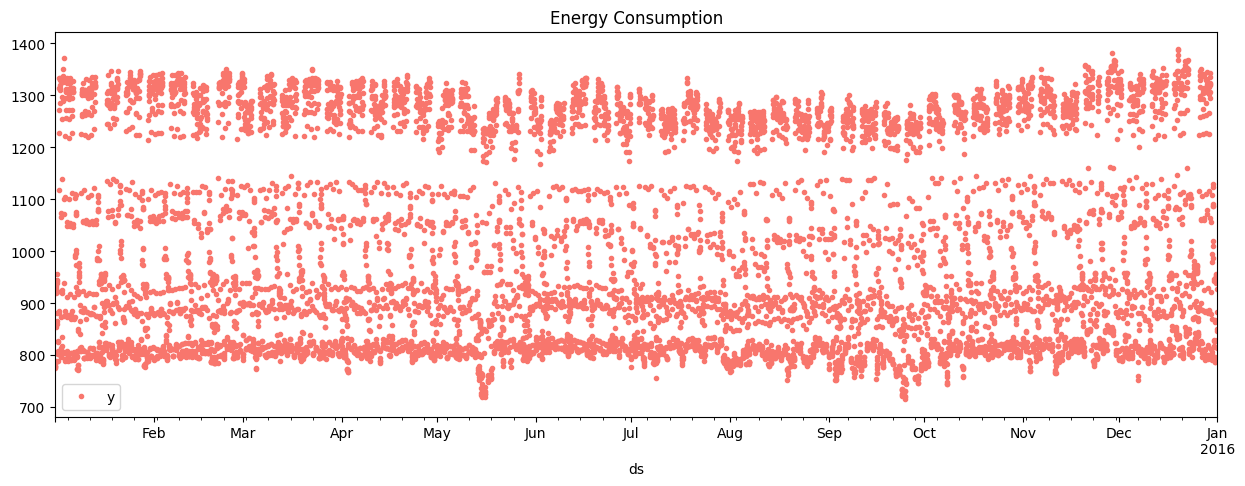

In [55]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy Consumption')

## Train/Test Split

2 months val window

In [15]:
time_split = '2015-12-29'

train = df.loc[df.index <= time_split].copy()
val = df.loc[df.index > time_split].copy()

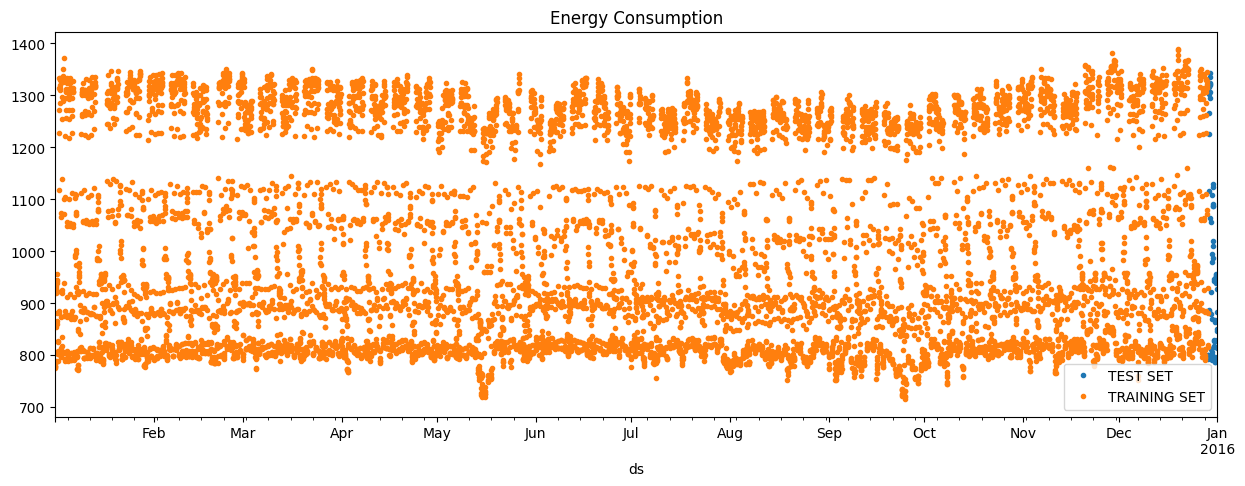

In [ ]:
_ = val \
    .rename(columns={'y': 'TEST SET'}) \
    .join(train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Energy Consumption', style='.')

# Creating Additional Timeseries Features:

We create additional time series features to capture temporal patterns and improve the model's performance.


In [16]:
def create_features(df, label=None) :
    """
    Creates time series features from datetime index.

    Parameters:
    df (pd.DataFrame): The input dataframe with datetime index.
    label (str): The name of the target variable column (optional).

    Returns:
    X (pd.DataFrame): DataFrame containing the time series features.
    y (pd.Series): Series containing the target variable if label is provided.
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

## Train Test Split with New Feature Creation

In [17]:
X_train, y_train = create_features(train, label='y')
X_test, y_test = create_features(val, label='y')

In [29]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
ds,,,,,,,,
2015-01-01 01:00:00,1,3,1,1,2015,1,1,1
2015-01-01 02:00:00,2,3,1,1,2015,1,1,1
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1
2015-01-01 05:00:00,5,3,1,1,2015,1,1,1
...,...,...,...,...,...,...,...,...
2015-12-30 20:00:00,20,2,4,12,2015,364,30,53
2015-12-30 21:00:00,21,2,4,12,2015,364,30,53
2015-12-30 22:00:00,22,2,4,12,2015,364,30,53


## Creating XGBoost Model

In [18]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Visualizing Feature Importance

To understand which features are most influential in our XGBoost model, we can plot the feature importance. This helps us interpret the model and identify the key factors driving energy consumption predictions.


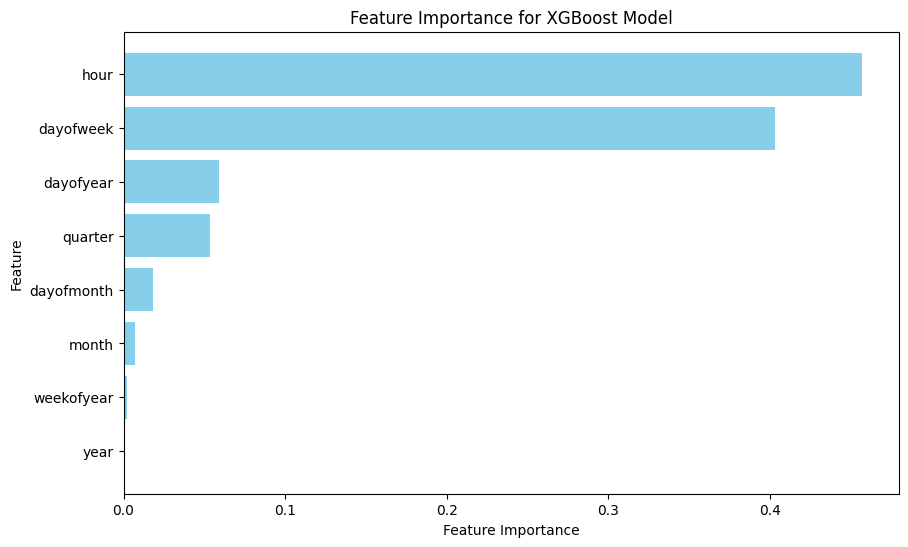

In [19]:
def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance for a given model.

    Parameters:
    model (XGBRegressor): Trained XGBoost model
    feature_names (list of str): List of feature names

    Returns:
    None: This function plots the feature importance
    """
    # Extract feature importances from the model
    importance = model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance for XGBoost Model')
    plt.gca().invert_yaxis()  # Invert y axis to show the highest importance at the top
    plt.show()

# Example usage
feature_names = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']

# Assuming you have already trained your xgb_model as shown in previous steps
plot_feature_importance(model, feature_names)

## Forecast on Test Set


In [20]:
val['y_hat'] = model.predict(X_test)
df_all = pd.concat([val, train], sort=False)

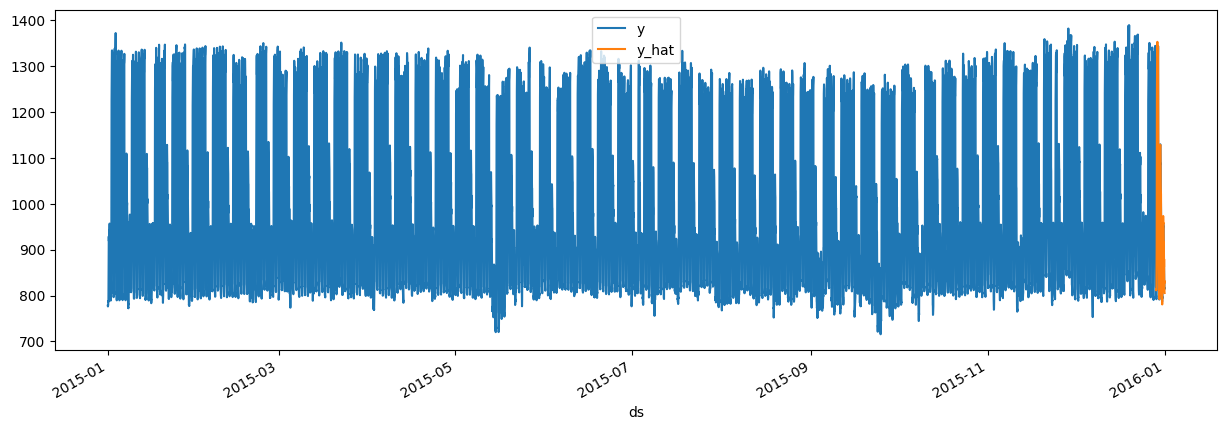

In [64]:
_ = df_all[['y','y_hat']].plot(figsize=(15, 5))


## Error Metrics On Test Set


In [21]:
def xgb_model_results(train,val,feature_names):

        X_train, y_train = create_features(train, label='y')
        X_test, y_test = create_features(val, label='y')

        X_train = X_train[feature_names]
        X_test = X_test[feature_names]
        model = xgb.XGBRegressor(n_estimators=1000)
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=50,
        verbose=False)
        val['y_hat'] = model.predict(X_test)
        df_all = pd.concat([val, train], sort=False)

        # Calculate evaluation metrics
        y_val = val['y']
        y_pred = val['y_hat']

        mae = mean_absolute_error(y_true=val['y'],
                                y_pred=val['y_hat'])

        mse = mean_squared_error(y_true=val['y'],
                                y_pred=val['y_hat'])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true=val['y'],
                                y_pred=val['y_hat'])
        r2 = r2_score(y_true=val['y'],
                                y_pred=val['y_hat'])

        print(f'Mean Absolute Error (MAE): {mae:.2f}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
        print(f'R-squared (R²): {r2:.2f}')

        model_results[f'XGB_{len(feature_names)}_features']={'MAE': mae,
                    'MAPE': mape,
                    'R²':r2 ,
                    'model':model}

        # Plot the actual vs predicted values
        plt.figure(figsize=(14, 7))
        plt.plot(y_val.index, y_val, label='Actual')
        plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Load')
        plt.title('Actual vs Predicted Energy Consumption (Validation Period) - sktime')
        plt.legend()
        plt.show()

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 14.61
Mean Squared Error (MSE): 344.29
Root Mean Squared Error (RMSE): 18.56
Mean Absolute Percentage Error (MAPE): 1.50%
R-squared (R²): 0.99


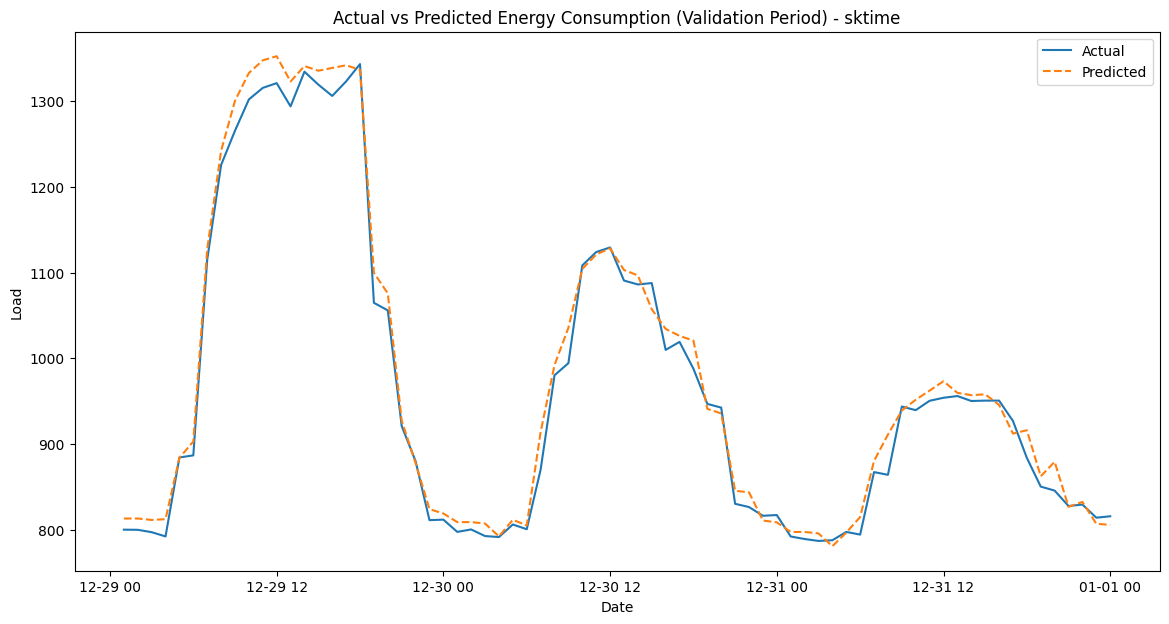

In [29]:
xgb_model_results(train,val,feature_names=['hour', 'dayofweek', 'quarter', 'month',
                                           'year', 'dayofyear', 'dayofmonth', 'weekofyear'])

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 14.72
Mean Squared Error (MSE): 338.50
Root Mean Squared Error (RMSE): 18.40
Mean Absolute Percentage Error (MAPE): 1.51%
R-squared (R²): 0.99


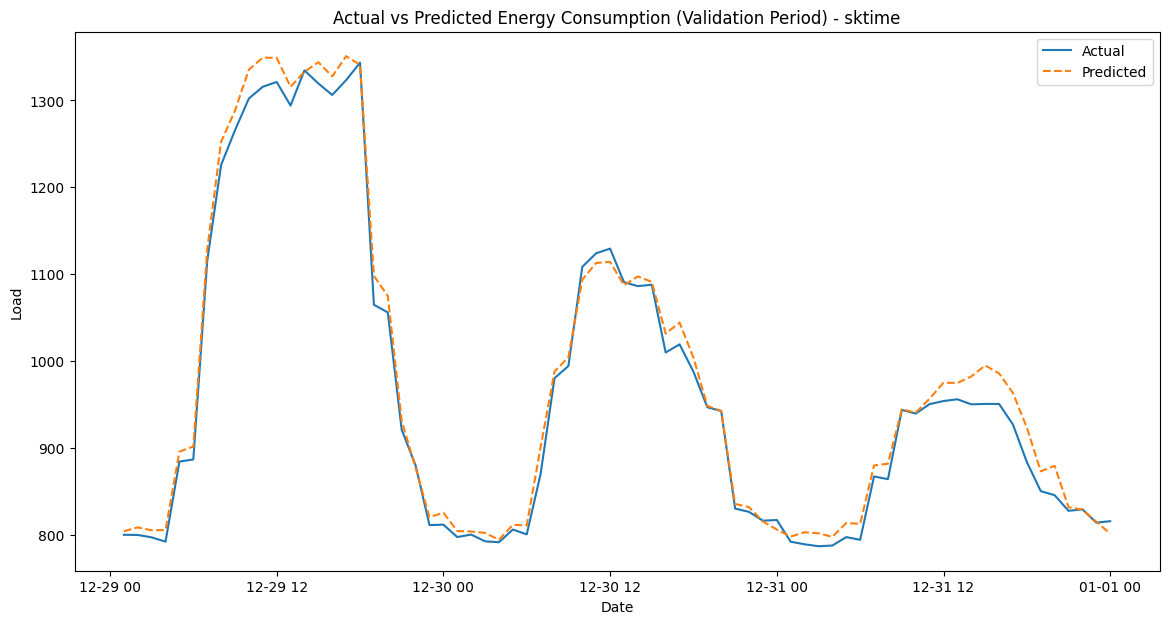

In [30]:
xgb_model_results(train,val,feature_names=['hour', 'dayofweek', 'dayofyear'])

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 35.12
Mean Squared Error (MSE): 2549.07
Root Mean Squared Error (RMSE): 50.49
Mean Absolute Percentage Error (MAPE): 3.53%
R-squared (R²): 0.92


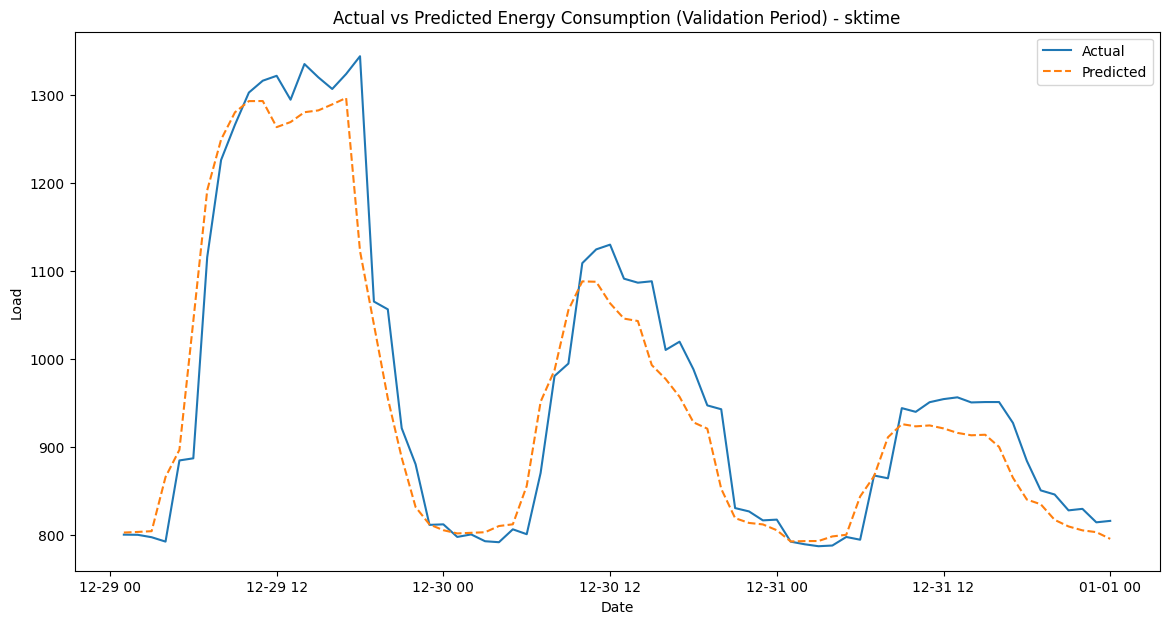

In [31]:
xgb_model_results(train,val,feature_names=['hour', 'dayofweek'])

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 109.85
Mean Squared Error (MSE): 16948.35
Root Mean Squared Error (RMSE): 130.19
Mean Absolute Percentage Error (MAPE): 11.37%
R-squared (R²): 0.45


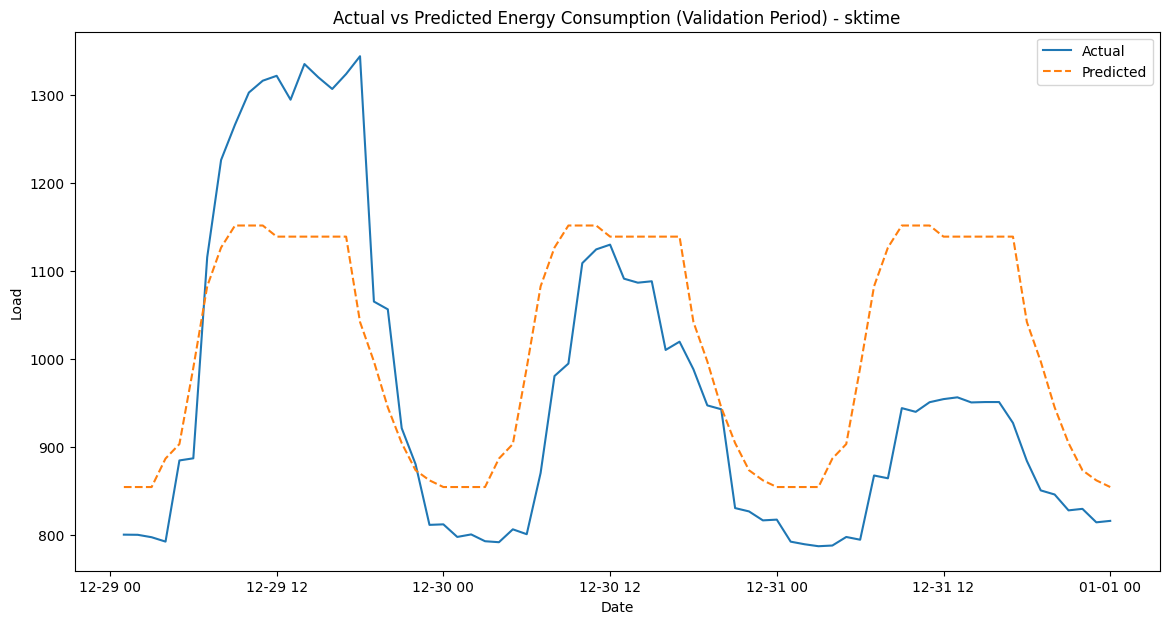

In [32]:
xgb_model_results(train,val,feature_names=['hour'])

In [33]:
model_results

{'Prophet': {'MAE': 67.02, 'MAPE': 6.76, 'R²': 0.82},
 'XGB_8_features': {'MAE': 14.609057871191412,
  'MAPE': 0.015006594469035838,
  'R²': 0.9887741144772852,
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)},
 'XGB_3_features': {'MAE': 14.719796207964416,
  'MAPE': 0.

The Best Model based on the MAPE Is XGB with All New Features 'hour', 'dayofweek', 'quarter', 'month',
                                           'year', 'dayofyear', 'dayofmonth', 'weekofyear'

In [37]:
import pickle
Best_model = model_results['XGB_8_features']['model']

# Save the trained model using pickle
with open(r'..\models\xgboost_energy_model.pkl', 'wb') as f:
    pickle.dump(Best_model, f)